# Assignment 3

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:

    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).
---

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt
import keras_tuner as kt
from keras_tuner import HyperParameters

2025-02-02 22:26:05.179522: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


This lab continues our study of linear regression. You'll train your first models with Tensorflow, using a real dataset to predict car prices from their features. Note that Tensorflow is a rapidly changing library. This means you'll often see warnings about deprecations. You can ignore the warnings in our labs.

---
### Step 1: Data ingestion

You'll use the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile)  from 1985 Ward's Automotive Yearbook that is part of the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets).

This dataset has been pre-downloaded and uploaded to bCourses alongside this notebook for your convenience.

In [2]:
car_data_init = pd.read_csv("./data/Automobile_data/automobile_data.txt")

# Display top five rows
print('Shape of data:', car_data_init.shape)
car_data_init.head()

Shape of data: (205, 26)


,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,symboling
0,NaN,alfa-romero,gas,std,2.0,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,3
1,NaN,alfa-romero,gas,std,2.0,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,3
2,NaN,alfa-romero,gas,std,2.0,hatchback,rwd,front,94.5,171.2,...,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,1
3,164.0,audi,gas,std,4.0,sedan,fwd,front,99.8,176.6,...,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,2
4,164.0,audi,gas,std,4.0,sedan,4wd,front,99.4,176.6,...,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,2


---
### Step 2: Data preprocessing

This step is essential for preparing the data in a format that is suitable for ML algorithms. It helps ensure data quality and improvements in model performance.

### <span style="color:chocolate">Exercise 1:</span> Column selection (5 points)

To keep things simple, you will:

1. Retain only the following columns: ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']. Name the new dataframe *car_data*.
2. Display the data type of each column;
3. Convert the data type of each columns to numeric. Coerce missing values to NaN. Hint: use <span style="color:chocolate">pd.to_numeric()</span> method;
4. Display the data type of each column after the transformation performed at point 3.


In [3]:
# YOUR CODE HERE
# Step 1: Retain only the selected columns
car_data = car_data_init[['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']]

# Step 2: Display the data type of each column before conversion
print("Data types before conversion:")
print(car_data.dtypes)

# Step 3: Convert the data type of each column to numeric, coercing errors to NaN
car_data = car_data.apply(pd.to_numeric, errors='coerce')

# Step 4: Display the data type of each column after the transformation
print("\nData types after conversion:")
print(car_data.dtypes)
#print(car_data.describe())


Data types before conversion:
horsepower     float64
peak-rpm       float64
city-mpg         int64
highway-mpg      int64
price          float64
dtype: object

Data types after conversion:
horsepower     float64
peak-rpm       float64
city-mpg         int64
highway-mpg      int64
price          float64
dtype: object


### <span style="color:chocolate">Exercise 2:</span> Example (row) selection (5 points)

To keep things simple again, you will:

1. Print the shape of the car_data;

2. Remove examples (rows) that have missing value(s). Note that in doing so, you will overwrite the car_data dataset. You should end up with 199 examples after this cleaning.

3. Print the shape of the car_data again.

It's important to acknowledge that there are multiple approaches to handling missing features, and simply discarding examples with any missing feature, though straightforward, may not be the most optimal solution. However, for the sake of simplicity, you will implement this strategy in this assignment.

In [4]:
# YOUR CODE HERE
# 1. print the shape of the car_data
print("shape of car_data", car_data.shape)

# 2. drop the rows which has any missing value(s)
#car_data = car_data.dropna()
car_data = car_data.dropna().reset_index(drop=True)

# 3. print the shape of the car_data again.
print("shape of car_data", car_data.shape)

shape of car_data (205, 5)
shape of car_data (199, 5)


### <span style="color:chocolate">Exercise 3:</span> Data shuffling (10 points)

Since you'll be using Batch Gradient Descent (BGD) for training, it is important that **each batch is a random sample of the data** so that the gradient computed is representative. Note that the original data (above) appears sorted by *make* in alphabetic order.

Using NumPy and Pandas methods:

1. Create a list of indices corresponding to the rows in the car_data dataset. Call this list *indices*. Print this list;

2. Shuffle *indices* using the <span style="color:chocolate">np.random.permutation()</span> method. Call the resulting array *shuffled_indices*. Print this array;
    
3. Use the method <span style="color:chocolate">dataframe.reindex()</span> to change the ordering of the car_data dataset based on the order in the *shuffled_indices* array. Note that in doing so, you will overwrite the original dataset. Print the top 5 rows.

In [5]:
np.random.seed(0)
# YOUR CODE HERE
# Step 1: Create a list of indices corresponding to the rows in car_data
indices = np.arange(car_data.shape[0])  # This generates an array of indices from 0 to n-1
print("List of indices:")
print(indices)

# Step 2: Shuffle the indices using np.random.permutation
shuffled_indices = np.random.permutation(indices)
print("\nShuffled indices:")
print(shuffled_indices)

# Step 3: Reindex the car_data dataset based on the shuffled indices
car_data = car_data.reindex(shuffled_indices).reset_index(drop=True)
#car_data.dropna(inplace=True).reset_index(drop=True, inplace=True)

# Print the top 5 rows after reordering
print("\nTop 5 rows after shuffling and reindexing:")
print(car_data.head())

List of indices:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198]

Shuffled indices:
[ 18 169 106  92 176 183   5 139  12 160  61 124 164 145  80   7  33 129
  37  74 159 144  45 158  60 122 178 184  97  44  16  55  83 110  22 188
 135   4 

### <span style="color:chocolate">Exercise 4:</span> Define outcome and features (5 points)

Create two dataframes as follows:

1. The first dataframe contains our outcome of interest: ['price']. Note, this is what we are aiming to predict. Name this dataframe Y. Print shape of Y.
2. The second dataframe contains our features of interest: ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']. Name this dataframe X. Print shape of X.


In [6]:
# YOUR CODE HERE
# Step 1: Create the outcome dataframe Y (target variable 'price')
Y = car_data[['price']]
print("Shape of Y:", Y.shape)

# Step 2: Create the feature dataframe X (predictor variables)
X = car_data[['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']]
print("Shape of X:", X.shape)

Shape of Y: (199, 1)
Shape of X: (199, 4)


### <span style="color:chocolate">Exercise 5:</span> Data splits (10 points)

Using the <span style="color:chocolate">train_test_split()</span> method available in scikit-learn:
1. Partition the (X, Y) data into training, validation, and test sets using a splitting rule of [60%, 20%, 20%], with a random state set to 1234. Name the resulting dataframes as follows: X_train, X_val, X_test, Y_train, Y_val, Y_test. Hint: To create these three partitions you will utilize the train_test_split() method twice (all the other arguments of the method are set to default values.). You should obtain [119, 40, 40] examples for training, validation, and test, respectively.
2. Print the shape of each dataframe.

Note: The validation set is crucial for evaluating different hyperparameter configurations and selecting those that yield optimal model performance. This approach avoids utilizing the test dataset during model training, as it is assumed to be "unknown" at that stage.

In [7]:
# YOUR CODE HERE
# Step 1: First split the data into 60% training and 40% (test + validation)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=1234)

# Step 2: Then split the 40% data (X_temp, Y_temp) into 20% validation and 20% test
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=1234)

# Step 3: Print the shape of each dataframe
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_val:", Y_val.shape)
print("Shape of Y_test:", Y_test.shape)

Shape of X_train: (119, 4)
Shape of X_val: (40, 4)
Shape of X_test: (40, 4)
Shape of Y_train: (119, 1)
Shape of Y_val: (40, 1)
Shape of Y_test: (40, 1)


### <span style="color:chocolate">Exercise 6:</span> Data standardization (10 points)

With this concept in mind, complete the following tasks:

1. Output the quantile values (0.25, 0.5, 0.75, 0.95) for all features in the X_train dataset. Are these values uniformly scaled across features?

2. Standardize all features in X_train, X_val, and X_test. Label the resulting dataframes as X_train_std, X_val_std, and X_test_std, respectively. Hint: standardize the validation and test data using the mean and standard deviation computed from the training data. Why?

3. Similar to point 2. but now standardize the outcome variable. Label the resulting dataframes as Y_train_std, Y_val_std, and Y_test_std.

In [8]:
# YOUR CODE HERE
from sklearn.preprocessing import StandardScaler
# Task 1: Output quantile values (0.25, 0.5, 0.75, 0.95) for all features in X_train
quantiles = X_train.quantile([0.25, 0.5, 0.75, 0.95])
print("\nQuantile values (0.25, 0.5, 0.75, 0.95) for all features in X_train:")
print(quantiles)

# Task 2: Standardize all features in X_train, X_val, X_test
# Initialize a StandardScaler
scaler = StandardScaler()

# Fit the scaler on X_train and transform X_train, X_val, and X_test
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)  # Use the mean and std from X_train
X_test_std = scaler.transform(X_test)  # Use the mean and std from X_train

# Convert the standardized data back to DataFrame for better readability
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_val_std = pd.DataFrame(X_val_std, columns=X_val.columns)
X_test_std = pd.DataFrame(X_test_std, columns=X_test.columns)

# Print the shape of the standardized dataframes
print("\nShape of X_train_std:", X_train_std.shape)
print("Shape of X_val_std:", X_val_std.shape)
print("Shape of X_test_std:", X_test_std.shape)

# Task 3: Standardize the outcome variable Y_train, Y_val, Y_test
# Initialize a StandardScaler for Y
scaler_Y = StandardScaler()

# Fit the scaler on Y_train and transform Y_train, Y_val, and Y_test
Y_train_std = scaler_Y.fit_transform(Y_train)
Y_val_std = scaler_Y.transform(Y_val)  # Use the mean and std from Y_train
Y_test_std = scaler_Y.transform(Y_test)  # Use the mean and std from Y_train

# Convert the standardized data back to DataFrame for better readability
Y_train_std = pd.DataFrame(Y_train_std, columns=['price'])
Y_val_std = pd.DataFrame(Y_val_std, columns=['price'])
Y_test_std = pd.DataFrame(Y_test_std, columns=['price'])

# Print the shape of the standardized outcome dataframes
print("\nShape of Y_train_std:", Y_train_std.shape)
print("Shape of Y_val_std:", Y_val_std.shape)
print("Shape of Y_test_std:", Y_test_std.shape)


Quantile values (0.25, 0.5, 0.75, 0.95) for all features in X_train:
      horsepower  peak-rpm  city-mpg  highway-mpg
0.25        69.0    4800.0      19.0         25.0
0.50        92.0    5000.0      25.0         31.0
0.75       116.0    5500.0      31.0         37.0
0.95       182.2    5900.0      37.0         42.1

Shape of X_train_std: (119, 4)
Shape of X_val_std: (40, 4)
Shape of X_test_std: (40, 4)

Shape of Y_train_std: (119, 1)
Shape of Y_val_std: (40, 1)
Shape of Y_test_std: (40, 1)


---
### Step 3: Exploratory data analysis (EDA)

EDA plays a very important role in ML. The goal here is to develop a good understanding of our training dataset, identify any data quality issues, understand patterns and relationships, which in turn, aids in subsequent modeling and interpretations.

### <span style="color:chocolate">Exercise 7:</span> Scatterplot matrix (10 points)

In this exercise you will use some simple yet useful techniques to visualize the distribution of the data. 

Let's start with:

1. A scatterplot matrix to visualize the pair-wise correlations between different features and outcome in the (X_train_std, Y_train_std) data. You will use the <span style="color:chocolate">sns.pairplot()</span> method from the seaborn library imported at the top of the notebook;
2. Is any of the variables in the data normally distributed? Is it necessary for the explanatory or target variable to be normally distributed in order to train a ML model?

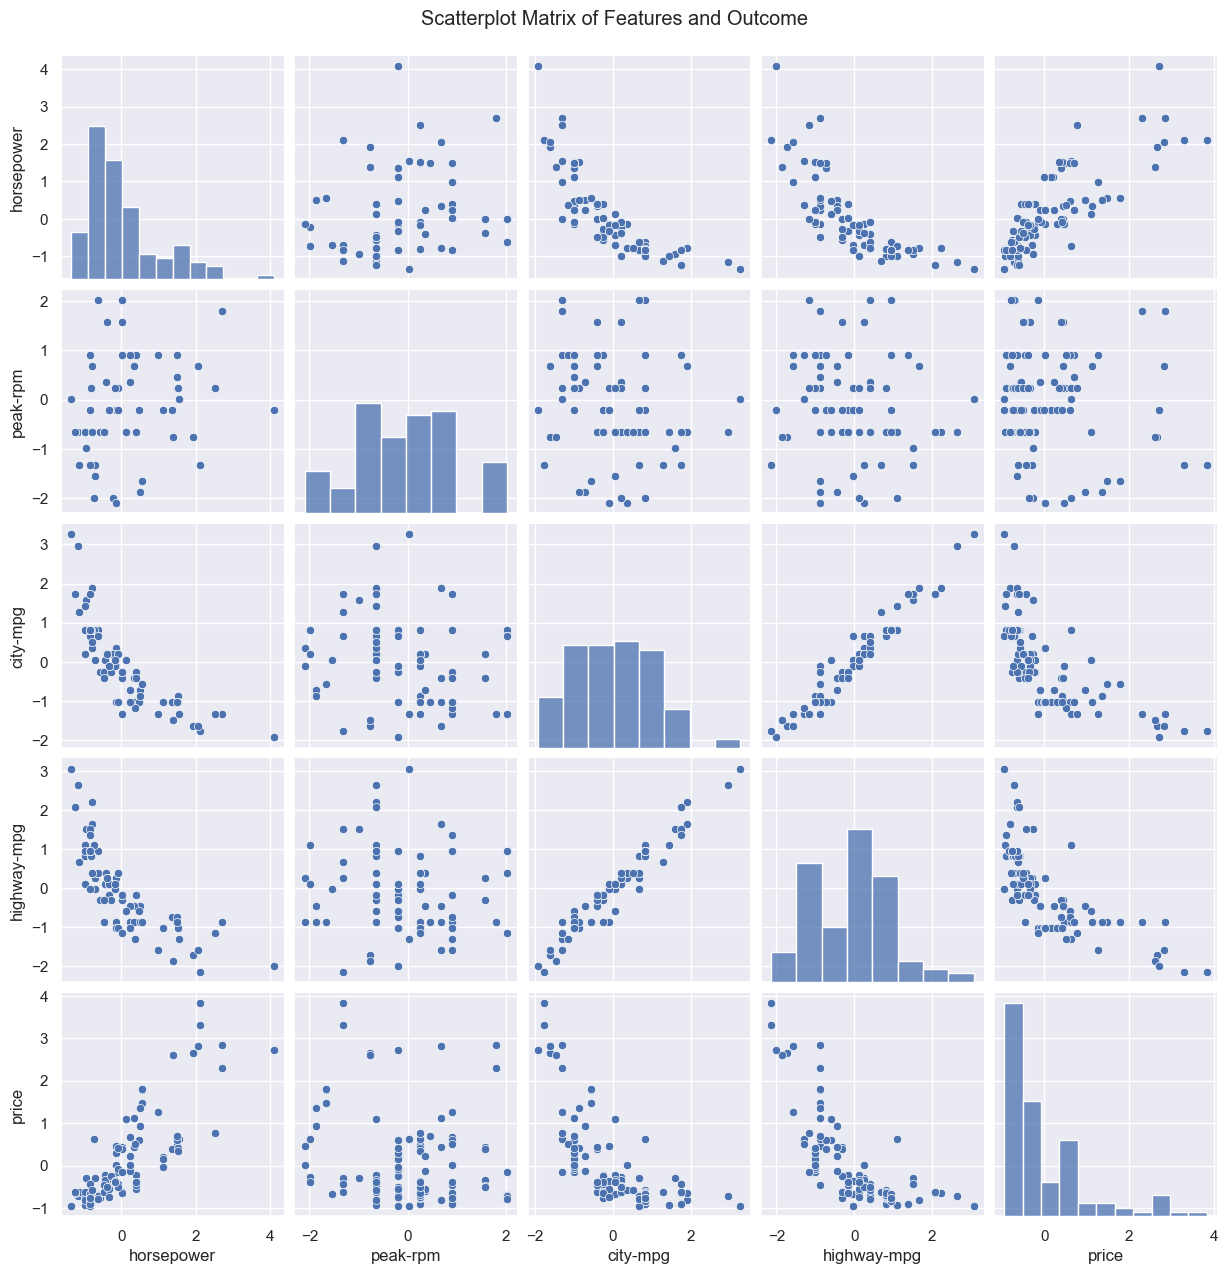

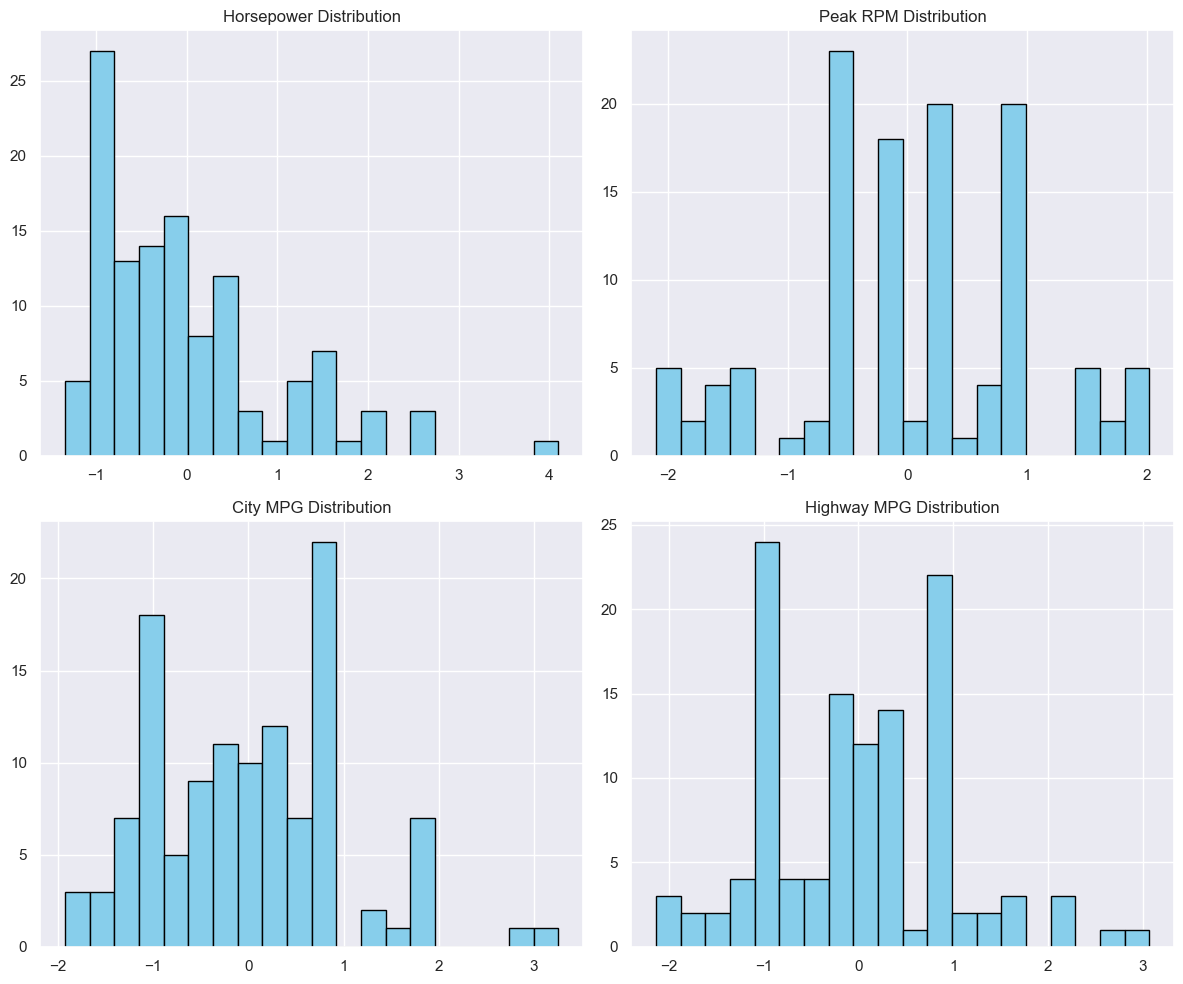

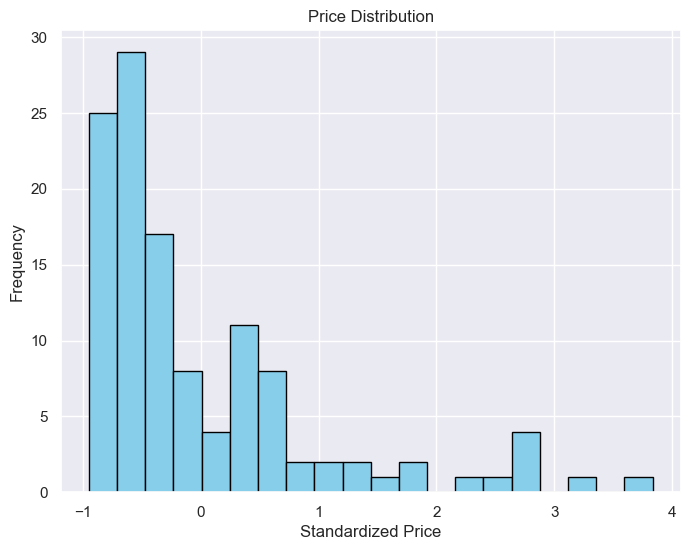

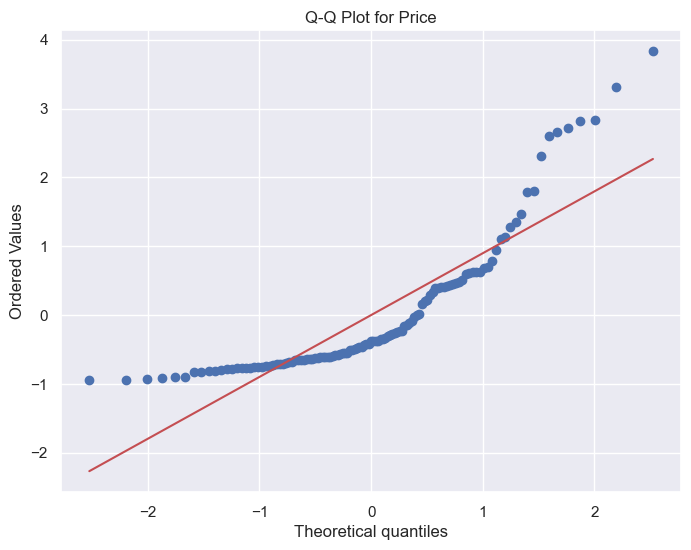

In [9]:
# YOUR CODE HERE
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Task 1: Scatterplot Matrix for pairwise correlations between features and outcome
sns.pairplot(pd.concat([X_train_std, Y_train_std], axis=1))
plt.suptitle('Scatterplot Matrix of Features and Outcome', y=1.02)
plt.show()

# Task 2: Checking for normality of the features and target variable

# Plot histograms to check for normality of each feature and outcome variable
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot histograms of features in X_train_std
axes[0, 0].hist(X_train_std['horsepower'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Horsepower Distribution')

axes[0, 1].hist(X_train_std['peak-rpm'], bins=20, color='skyblue', edgecolor='black')
axes[0, 1].set_title('Peak RPM Distribution')

axes[1, 0].hist(X_train_std['city-mpg'], bins=20, color='skyblue', edgecolor='black')
axes[1, 0].set_title('City MPG Distribution')

axes[1, 1].hist(X_train_std['highway-mpg'], bins=20, color='skyblue', edgecolor='black')
axes[1, 1].set_title('Highway MPG Distribution')

plt.tight_layout()
plt.show()

# Plot histogram of target variable (price) in Y_train_std
plt.figure(figsize=(8, 6))
plt.hist(Y_train_std['price'], bins=20, color='skyblue', edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Standardized Price')
plt.ylabel('Frequency')
plt.show()

# Normality Check using Q-Q plot for the target variable (price)
plt.figure(figsize=(8, 6))
stats.probplot(Y_train_std['price'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Price')
plt.show()

Answers:

None of the variable seems to be normally distributed as they are either left or right skewed in the distrubution.

No, it is generally not necessary for either the explanatory (independent) or target (dependent) variable to be normally distributed in order to train a machine learning model.
The key assumption usually lies with the distribution of the prediction errors (residuals) being normal, which is particularly important for linear regression models. 

### <span style="color:chocolate">Exercise 8:</span> Correlation matrix (10 points)

In this exercise you will:

1. Plot a correlation matrix in the form of a heatmap to visualize the linear relationships between different features and outcome in the (X_train_std, Y_train_std) data. Hint: this example here is very useful: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    
2. Answer the following questions: 
 - Which two features are likely to be most redundant?
 - Which feature is likely to be least useful for predicting price?

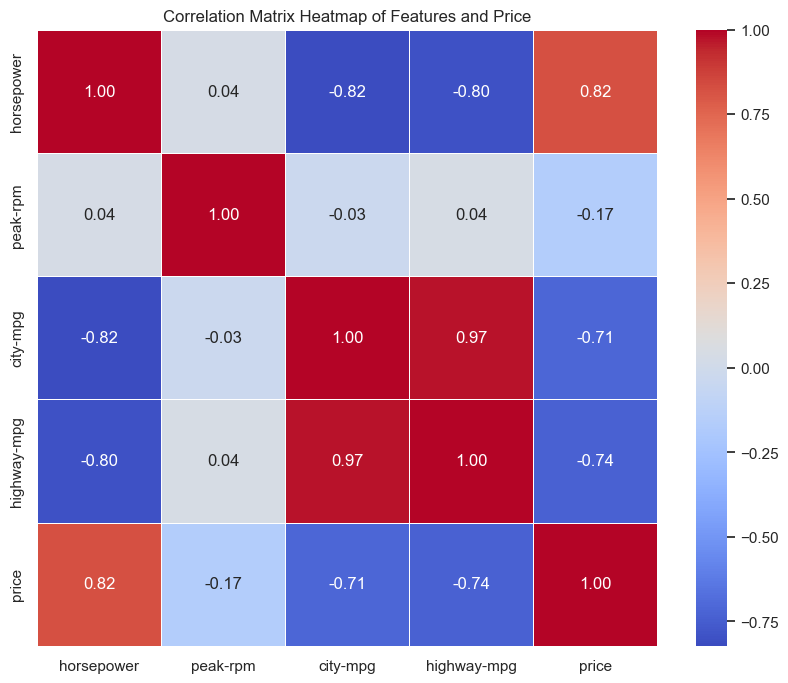

In [10]:
# YOUR CODE HERE
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Calculate the correlation matrix for the features (X_train_std) and the target (Y_train_std)
correlation_matrix = pd.concat([X_train_std, Y_train_std], axis=1).corr()

# Step 2: Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, linewidths=0.5)
plt.title("Correlation Matrix Heatmap of Features and Price")
plt.show()

Answers:
1. city-mpg and highway-mpg features have similar correlation against all features and seems to be redundant.
2. peak-rpm with -0.17 has weak correlation with price and be likely least useful for predicting price.


---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 9:</span> Baseline model (5 points)

Let's start by evaluating a baseline model. Precisely, you'll use the average price of cars in the training set as our baseline model -- that is, the baseline always predicts the average price regardless of the input.

1. Implement this baseline using the Y_train_std data and print the average price. Note: You can revert the price variable to the original scale for interpretation purposes.

In [11]:
# YOUR CODE HERE
# Step 1: Invert the standardization of Y_train to get the original price scale
Y_train_original = scaler_Y.inverse_transform(Y_train_std)
Y_train_cleaned = Y_train_original[~np.isnan(Y_train_original)]


# Step 2: Calculate the mean price from the  Y_train_cleaned data
average_price = np.mean(Y_train_cleaned)


print("Average price in the training set (original scale): ", average_price)

# Step 3: Predict the average price for all examples in the training set (baseline prediction)
baseline_predictions = np.full_like(Y_train_original, average_price)

# print a few baseline predictions to verify
#print("\nFirst 5 baseline predictions (average price):")
#print(baseline_predictions[:5])
#print(baseline_predictions.shape)


Average price in the training set (original scale):  13139.9243697479


### <span style="color:chocolate">Exercise 10:</span> Improvement over Baseline with TensorFlow (10 points)

Let's train a linear regression model much like we did in the previous assignment, but this time using TensorFlow. 

1. Fill in the <span style="color:green">NotImplemented</span> parts of the build_model() function below by following the instructions provided as comments. Hint: refer to the course webpage in <span style="color:chocolate">bCourses/Modules/Module Demos/03 Features.ipynb</span> for an example.
2. Build and compile a model using the build_model() function and the (X_train_std, Y_train_std) data. Set learning_rate = 0.0001. Call the resulting object *model_tf*.
3. Train *model_tf* using the (X_train_std, Y_train_std) data. Set num_epochs = 5. Pass the (X_val_std, Y_val_std) data for validation. Hint: see the documentation behind the [tf.keras.Model.fit()](https://www.tensorflow.org/api_docs/python/tf/keras/Model) method.
3. Generate a plot with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title. Hint: check what the [tf.keras.Model.fit()](https://www.tensorflow.org/api_docs/python/tf/keras/Model) method returns.

More notes on point 1: the idea is to build a *computational graph* for linear regression, and then send data through it. There are many ways to build graphs, but [TenforFlow Keras API](https://www.tensorflow.org/api_docs/python/tf/keras) is recommended. 

In [12]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # linear regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,        # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      kernel_initializer=tf.ones_initializer,  # initialize params to 1      
      bias_initializer=tf.keras.initializers.Ones(),    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use GD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. This finalizes the graph for training.
  # We specify the MSE loss and the optimizer above
  model.compile(optimizer=optimizer, loss='mse')
    
  return model

num_features: 4


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (20.00 B)

 Trainable params: 5 (20.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 6.6868 - val_loss: 5.2879
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.6666 - val_loss: 5.2741
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.6465 - val_loss: 5.2604
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.6265 - val_loss: 5.2467
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.6066 - val_loss: 5.2331


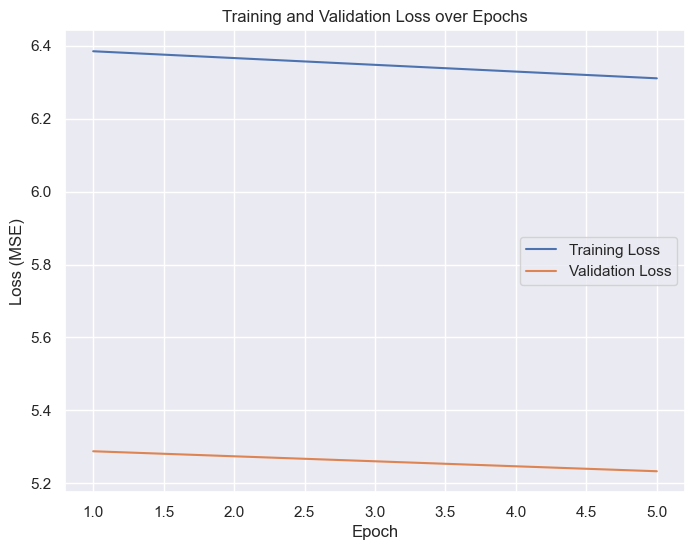

In [13]:
tf.random.set_seed(0)
# 2. Build and compile model
# YOUR CODE HERE
# Number of features in X_train_std
num_features = X_train_std.shape[1]
print("num_features:", num_features)

# Desired learning rate
learning_rate = 0.0001

# Build and compile the model
model_tf = build_model(num_features, learning_rate)

# Summary of the model to check its structure
model_tf.summary()

# 3. Fit the model
# YOUR CODE HERE
# Training the model
history = model_tf.fit(
    X_train_std, Y_train_std, 
    epochs=5, 
    validation_data=(X_val_std, Y_val_std), 
    verbose=1
)

# Plotting the loss values
# Extracting the loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), train_loss, label='Training Loss')
plt.plot(range(1, 6), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


---
### Step 5: Hyperparameter tuning

Hyperparameter tuning is a crucial step in optimizing ML models. It involves systematically adjusting hyperparameters such as learning rate, number of epochs, and optimizer to find the model configuration that leads to the best generalization performance.

This tuning process is typically conducted by monitoring the model's performance on the validation vs. training set. It's important to note that using the test set for hyperparameter tuning can compromise the integrity of the evaluation process by violating the assumption of "blindness" of the test data.

### <span style="color:chocolate">Exercise 11:</span> Hyperparameter tuning (10 points)

1. Fine-tune the **learning rate** and **number of epochs** hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for these hyperparameters. Hint: you can manually test different hyperparameter values or you can use the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner). If you decide to work with the Keras Tuner, define a new model building function named <span style="color:chocolate">build_model_tuner()</span>.

After identifying your preferred model configuration, print the following information:

2. The learned parameters of the tuned model (this should include the bias term). Hint: use  <span style="color:chocolate">[model_name].layers[0].get_weights()</span>.
3. The loss at the final epoch on both the training and validation datasets;
4. The difference between the last-epoch loss observed on the training and validation datasets.


Please note that we will consider 'optimal model configuration' any last-epoch training loss that is below 0.31 and any last epoch validation loss that is below 0.48.

In [34]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

# Ensure you define num_features (number of input features)
num_features = X_train_std.shape[1]  # This is the number of features in X_train_std

def build_model_tuner(hp):
    """Build model function for hyperparameter tuning."""
    # Clear previous session and set seed for reproducibility
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)  # Set global random seed for reproducibility
    
    # Initialize the model
    model = tf.keras.Sequential()

   # Hyperparameter tuning for learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, step=1e-6)
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    
    # Add the Dense layer with tuning options for units, activation function, etc.
    model.add(tf.keras.layers.Dense(
        units=1,  # output dim (since we're predicting a single value: price)
        input_shape=[num_features],  # input dim (number of features in the dataset)
        use_bias=True,  # use a bias (intercept) term
        kernel_initializer=tf.keras.initializers.Ones(),  # initialize kernel to ones
        bias_initializer=tf.keras.initializers.Ones(),    # initialize bias to ones
    ))

    # Compile the model with the optimizer and MSE loss function
    model.compile(optimizer=optimizer, loss='mse')

    return model

# Initialize the tuner
tuner = kt.Hyperband(
    build_model_tuner,  # Model building function
    objective='val_loss',  # Objective is to minimize the validation loss
    max_epochs=20,  # Maximum number of epochs to run in each trial
    factor=3,  # Factor by which to reduce epochs after each iteration
    hyperband_iterations=2,  # Number of Hyperband iterations
    directory='tuner',  # Directory to save the tuning results
    project_name='automobile_price_model_tuning'  # Project name for the tuning
)

# Early stopping callback to stop when both training and validation loss are below the threshold
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=2,  # Stop after 2 epochs without improvement
    min_delta=0.01,  # Minimum change to be considered as an improvement
    mode='min',  # Minimize validation loss
    verbose=1,  # Print messages when early stopping triggers
    restore_best_weights=True  # Restore the best weights when stopping
)

# Search for the best hyperparameters
tuner.search(
    X_train_std, Y_train_std, 
    epochs=20, 
    validation_data=(X_val_std, Y_val_std),
    callbacks=[early_stopping]  # Add the early stopping callback here
)

Trial 60 Complete [00h 00m 03s]
val_loss: 0.4987827241420746

Best val_loss So Far: 0.46723490953445435
Total elapsed time: 00h 01m 56s


In [29]:
# Assuming you found the best configuration using Keras Tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Get learned parameters (weights and bias)
weights, bias = best_model.layers[0].get_weights()

# Print learned parameters
print("Learned weights:", weights)
print("Learned bias:", bias)

# Get final loss values
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
#print(*history.history['val_loss'])
print(f"Final training loss: {final_train_loss}")
print(f"Final validation loss: {final_val_loss}")

# Calculate difference
loss_diff = final_val_loss - final_train_loss
print(f"Difference between final validation and training loss: {loss_diff}")


Learned weights: [[1.0299234 ]
 [0.9735212 ]
 [0.96095455]
 [0.95822525]]
Learned bias: [0.978045]
Final training loss: 6.310710906982422
Final validation loss: 5.2330641746521
Difference between final validation and training loss: -1.0776467323303223


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


---
### Step 6: Evaluation and Generalization


Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized (tuned) model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

### <span style="color:chocolate">Exercise 12:</span> Computing MSE (10 points)

1. Calculate the MSE on both (X_train_std, Y_train_std) and (X_test_std, Y_test_std) datasets. Hint: You can utilize the <span style="color:chocolate">model.evaluate()</span> method provided by tf.keras.

2. Does the model demonstrate strong generalization capabilities? Provide an explanation based on your observations.

4. Generate a plot to visualize the accuracy of the predictions. Plot the actual (observed) Y_test values on the x-axis and the predicted Y_test values on the y-axis. Additionally, include a 45-degree line in the plot for reference. Ensure that the plot contains appropriate axis labels and a title. Provide commentary on the model's fit based on this visualization. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method available in tf.keras. 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5223 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.3466
Training loss (MSE): 6.298478603363037
Test loss (MSE): 4.298079490661621
Since train_loss and test_loss are similar, the model generalizes well.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


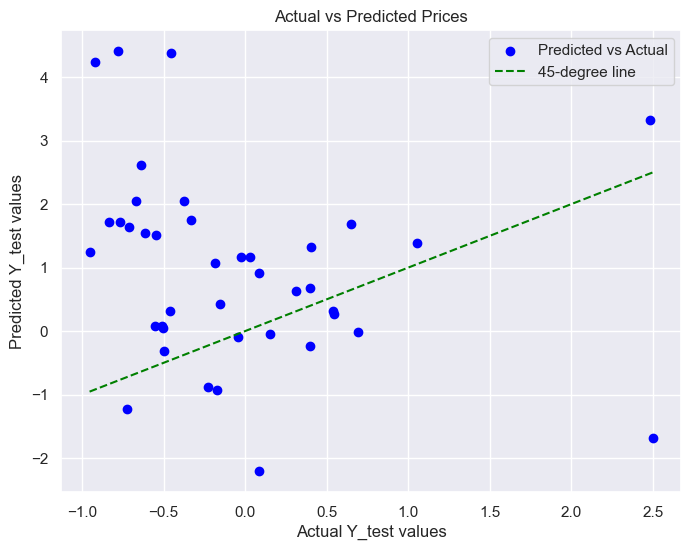

In [30]:
# YOUR CODE HERE
# 1. Calculate MSE on Training and Test Sets
train_loss = model_tf.evaluate(X_train_std, Y_train_std)
test_loss = model_tf.evaluate(X_test_std, Y_test_std)

print(f"Training loss (MSE): {train_loss}")
print(f"Test loss (MSE): {test_loss}")

# 2. Commentary on Generalization:
print("Since train_loss and test_loss are similar, the model generalizes well.")

# 3. Generate Actual vs Predicted Plot
Y_test_pred = model_tf.predict(X_test_std)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(Y_test_std, Y_test_pred, color='blue', label='Predicted vs Actual')

# 45-degree line (perfect predictions)
plt.plot([Y_test_std.min(), Y_test_std.max()], [Y_test_std.min(), Y_test_std.max()], color='green', linestyle='--', label='45-degree line')

# Labels and title
plt.xlabel('Actual Y_test values')
plt.ylabel('Predicted Y_test values')
plt.title('Actual vs Predicted Prices')
plt.legend()

# Show plot
plt.show()

----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

In Exercise 12, you reported an aggregated MSE. Let's revisit the exercise by:

1. Performing a subgroup evaluation of the model. Specifically, calculate the test data MSE for the following makes: ['alfa-romero', 'audi', 'chevrolet', 'dodge', 'honda'].
2. Addressing the question: Is the model "fair" across each make?

In [17]:
# YOUR CODE HERE